<a href="https://colab.research.google.com/github/lszam/plates/blob/main/expansao_de_grid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.interpolate import griddata

#Função
def GradHoriz(vetor, nx, ny, dx, dy):
  dx2 = 2*dx
  dy2 = 2*dy
  vetor_GH = np.ones(nx*ny)
  for j in range(1, ny+1):
    jm1 = j - 1
    if jm1 < 1: #condição de borda
      jm1 = 1
    jp1 = j + 1
    if jp1 > ny: #condição de borda
      jp1 = ny
    for i in range(1, nx+1):
      im1 = i - 1
      if im1 < 1: #condição de borda
        im1 = 1
      ip1 = i + 1
      if ip1 > nx: #condição de borda
        ip1 = nx
      #index(i,j,nx) = (j-1) * nx + i #função index em Blakely (1996)
      indexip1 = (jp1-1) * nx + (i-1)
      indexim1 = (j-1) * nx + (im1-1)
      indexjp1 = (jp1-1) * nx + (i-1)
      indexjm1 = (j-2) * nx + (i-1)
      #Análise de valores no espaço
      dfdx = (vetor[indexip1]-vetor[indexim1]) / dx2
      dfdy = (vetor[indexjp1]-vetor[indexjm1]) / dy2
      ij = (j-1) * nx + (i-1)
      vetor_GH[ij] = np.sqrt(dfdx**2+dfdy**2)

  #As linhas a seguir são ativada se for preciso retornar um grid
  #grid_GH = np.reshape(vetor_GH, (ny, nx))
  #return grid_GH

  return vetor_GH

In [2]:
df_S1 = pd.read_csv('python_interp_s1.csv')
df_S1

,Unnamed: 0,X,Y,Z
0,0,-6487.507399,-3517.382988,-560.609149
1,1,-6402.413424,-3517.265341,-565.368797
2,2,-6416.255376,-3506.692189,-507.614065
3,3,-6253.640288,-3504.445250,-550.692515
4,4,-6336.833676,-3504.439326,-561.058966
...,...,...,...,...
1213,1213,-5897.729012,-1734.937904,-372.616756
1214,1214,-5760.401755,-1731.475563,-381.978977
1215,1215,-5879.643841,-1728.309077,-341.750057
1216,1216,-5852.254572,-1718.269982,-341.776770


In [3]:
#valores em x sem repetição
len(df_S1['X'].unique())

1217

In [4]:
#tratamento para criar um grid com células de tamanho inteiro
cell=int(50)
X = df_S1['X'].values
Y = df_S1['Y'].values
Z = df_S1['Z'].values
#Arrays com X e Y com espaçamento regular
X_new, new_xcoord = [np.ceil(min(X))], np.ceil(min(X))
Y_new, new_ycoord = [np.ceil(min(Y))], np.ceil(min(Y))
for xcoord in X:
  while new_xcoord < xcoord:
    new_xcoord = new_xcoord + cell
    X_new.append(new_xcoord)
for ycoord in Y:
  while new_ycoord < ycoord:
    new_ycoord = new_ycoord + cell
    Y_new.append(new_ycoord)
xi, yi = np.meshgrid(X_new, Y_new)
zi = griddata((X, Y), Z, (xi, yi), method='linear')

In [5]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Surface(z=zi, x=xi, y=yi)])
fig.show()

In [6]:
ponto_especifico = griddata((xi.flatten(), yi.flatten()), zi.flatten(), [(-6000, -2500)], method='linear')
ponto_especifico[0]

-295.4817559237773

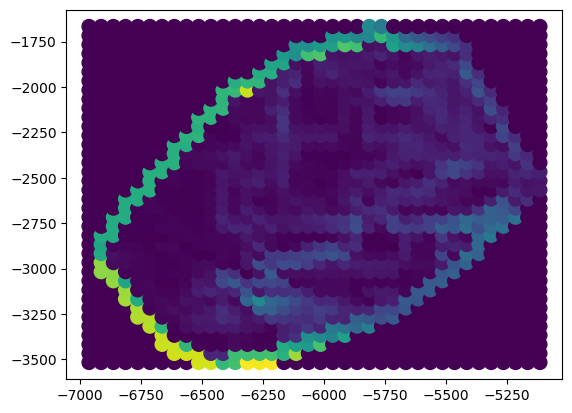

In [7]:
#GHT sem a expansão
vetor_X = xi.flatten()
vetor_Y = yi.flatten()
vetor_Z = zi.flatten()
pontos_X=[]
pontos_Y=[]
[pontos_X.append(item) for item in vetor_X if not pontos_X.count(item)]
[pontos_Y.append(item) for item in vetor_Y if not pontos_Y.count(item)]
#Número de itens a leste e a norte
nx = np.size(pontos_X)
ny = np.size(pontos_Y)
#Distancia entre pontos em x e y
dx, dy = np.abs(pontos_X[0]-pontos_X[1]), np.abs(pontos_Y[0]-pontos_Y[1])
vetor_Z = np.nan_to_num(vetor_Z, nan=0) # Substituir NaN por 0
vetor_GH = GradHoriz(vetor_Z, nx, ny, dx, dy)
df_S1_new = pd.DataFrame({'X': vetor_X, 'Y': vetor_Y, 'Z': vetor_Z, 'GHT': vetor_GH})
plt.scatter(df_S1_new['X'],df_S1_new['Y'],c=df_S1_new['GHT'], s=100)

Old size: 38 38 New: 58.0 58.0
New itens at horizontal and vertical sides: 10.0 10.0


<function matplotlib.pyplot.show(close=None, block=None)>

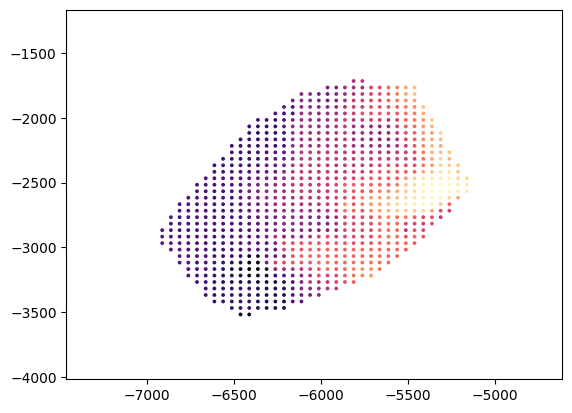

In [95]:
expansion_factor = 1.5

# Calcular o novo tamanho do grid
n_x = np.shape(xi)[1]
n_y = np.shape(yi)[0]
n_xborder = np.ceil(((xi.shape[0] * expansion_factor) - xi.shape[0]) / 2)
n_yborder = np.ceil(((yi.shape[1] * expansion_factor) - yi.shape[0]) / 2)
new_size_x = np.shape(xi)[1] + n_xborder*2
new_size_y = np.shape(yi)[0] + n_yborder*2
print("Old size:", n_x, n_y, "New:", new_size_x, new_size_y)
print("New itens at horizontal and vertical sides:", n_xborder, n_yborder) #por hora este valor precisa ser numero inteiro
# Localizar os índices de x e y mínimos e máximos
indice_min_x = np.unravel_index(np.argmin(xi), xi.shape)
indice_min_y = np.unravel_index(np.argmin(yi), yi.shape)
indice_max_x = np.unravel_index(np.argmax(xi), xi.shape)
indice_max_y = np.unravel_index(np.argmax(yi), yi.shape)
# Calcular os novos x e y mínimos
new_xi_min = xi.min() - (n_xborder * cell)
new_yi_min = yi.min() - (n_yborder * cell)
new_xi_max = xi.max() + (n_xborder * cell)
new_yi_max = yi.max() + (n_yborder * cell)
# Criar uma nova grade expandida para X e Y
x_expanded = np.linspace(new_xi_min, new_xi_max, int(new_size_x))
y_expanded = np.linspace(new_yi_min, new_yi_max, int(new_size_y))
xi_exp, yi_exp = np.meshgrid(x_expanded, y_expanded)
zi_exp = np.empty((np.shape(xi_exp)[1], np.shape(yi_exp)[0]))
zi_exp[:] = np.nan

# Criar uma máscara booleana onde zi não é NaN
mask_nan = np.isnan(zi)
# Encontrar os índices onde zi não é nulo (não é NaN)
valid_values_indexes = np.where(~mask_nan)
# valid_values_indexes é uma tupla de dois arrays
#valid_values_lin, valid_values_col = valid_values_indexes
for valid_l in valid_values_indexes[0]:
  for valid_c in valid_values_indexes[1]:
    # encontrar o valor real de x e y da nova posicao (no grid expandido)
    x_, y_ = xi[valid_l, valid_c], yi[valid_l, valid_c]
    # encontrar o indice da nova posicao em zi_exp (grid zi expandido)
    new_coord = np.where(np.logical_and(xi_exp == x_, yi_exp==y_))
    zi_exp[new_coord[0][0]][new_coord[1][0]] = zi[valid_l, valid_c]

plt.scatter(xi_exp, yi_exp, c=zi_exp, cmap='magma', s=3)
plt.xlim(np.min(xi_exp),np.max(xi_exp))
plt.ylim(np.min(yi_exp),np.max(yi_exp))
plt.show

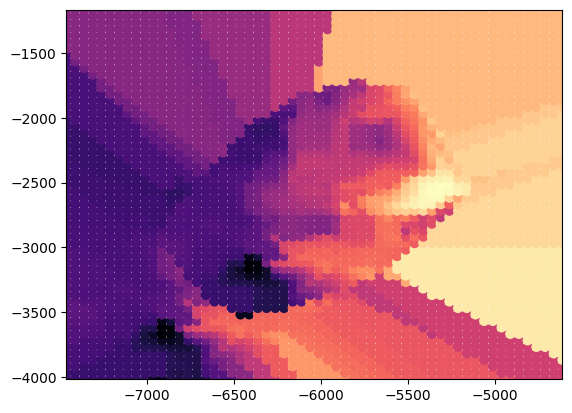

In [96]:
from scipy.spatial import cKDTree

# Encontre os índices onde zi não é NaN
valid_values_indexes = np.where(~mask_nan)
# Crie uma matriz de índices válidos
valid_points = np.array(valid_values_indexes).T
# Crie uma árvore KD para consulta de vizinhos
tree = cKDTree(valid_points)
# Encontre os índices dos pontos vazios
empty_points = np.transpose(np.where(np.isnan(zi_exp)))
# Para cada ponto vazio, encontre o ponto válido mais próximo e use o seu valor
for empty_point in empty_points:
    distance, valid_idx = tree.query(empty_point)
    zi_exp[tuple(empty_point)] = zi[tuple(valid_points[valid_idx])]
# Plote o resultado
plt.scatter(xi_exp, yi_exp, c=zi_exp, cmap='magma', s=40)
plt.xlim(np.min(xi_exp), np.max(xi_exp))
plt.ylim(np.min(yi_exp), np.max(yi_exp))
plt.show()
